<a href="https://colab.research.google.com/github/karenbennis/Xy/blob/analysis_visuals/yelp_reviews_visuals_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Connect to Database**

In [1]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

#Interact with SQL
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

# Start Spark Session(Creating spark application with name defined by appName()) ---IMPORTED WITH EVERY COLAB NOTEBOOK
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("database_transformation").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

--2020-07-22 12:38:55--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  4.74MB/s    in 0.2s    

2020-07-22 12:38:55 (4.74 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [2]:
# Authenticate user
from google.colab import auth
auth.authenticate_user()

In [3]:
# Set project id
project_id = 'xy-yelp'

In [4]:
# Set project
!gcloud config set project {project_id}

Updated property [core/project].


In [5]:
# Get file which was saved to bucket **** file saves as multiple files so this should be addressed in the future, for now the 11mb file should be fine
!gsutil cp -r gs://xy-bucket/json_files/ml_j.json/part-00000-f8a8f21c-0ebe-434c-a8b3-a5c8988dd298-c000.json /tmp/machine_json.json

Copying gs://xy-bucket/json_files/ml_j.json/part-00000-f8a8f21c-0ebe-434c-a8b3-a5c8988dd298-c000.json...
- [1 files][ 62.5 MiB/ 62.5 MiB]                                                
Operation completed over 1 objects/62.5 MiB.                                     


In [6]:
# Set filepath to tmp folder where bucket file was saved **** this could actually be done without saving to the bucket, this is just done to make sure we can 
# save to and read from bucket if we need to
filepath = '/tmp/machine_json.json'

In [7]:
# Import pandas and read json file into DataFrame
import pandas as pd
raw_json = pd.read_json(filepath, lines=True)

In [8]:
#Drop useless columns
raw_json=raw_json[['review_id','stars','class','review_text','length','cool','useful','funny','business_id','user_id']]

In [9]:
# Show dataframe
raw_json.head()

,review_id,stars,class,review_text,length,cool,useful,funny,business_id,user_id
0,-7yxrdY13ay15rGB7WibMA,5,1,I have been going to Arizona Auto Care since a...,670,0,0,0,Lh9nz0KYyzE-YRbKuCYeUw,ayKW9eWwGFcrtJaHcwZUCw
1,-Be0UUGYuiDJVAM_YqeQuA,4,1,"Since Im big into breakfast foods, Im always o...",1348,0,2,2,pa6K7DGByxBXxcVJ59nWMw,_4lqpCYCqOQzbB6xQGGhrQ
2,-nQHHXi-d_yuW301_Y0EZQ,2,0,"A pleasant place in Kierland Center, but has g...",813,0,0,0,GIGI8bJfN6HyPzmEW-QqjA,4QORbyhfN01oKR_GgBstfQ
3,2L30O7G8IQ6HILpR0t5RFA,5,1,"part of a social event, we only had app's here...",415,0,0,0,qiwajZigq_2twTmYofPmDQ,ST8Yzlk2MqKlcaLqL2djBg
4,4x5yLG7_yGLuN-w6fV0eBw,4,1,I love every place on South Mountain. I've bee...,302,0,1,0,9yKzy9PApeiPPOUJEtnvkg,Vk-hJ1i5ZagPM87Kv9FOnA


In [10]:
raw_json.dtypes

review_id      object
stars           int64
class           int64
review_text    object
length          int64
cool            int64
useful          int64
funny           int64
business_id    object
user_id        object
dtype: object

In [11]:
raw_json['stars']=raw_json['stars'].astype(str)
raw_json.dtypes

review_id      object
stars          object
class           int64
review_text    object
length          int64
cool            int64
useful          int64
funny           int64
business_id    object
user_id        object
dtype: object

In [49]:
stars_count = raw_json.stars.value_counts()
df = pd.DataFrame(stars_count).sort_index()
df.head()

,stars
1,749
2,927
3,1461
4,3526
5,3337


**Visualizations**

(array([3337.,    0., 3526.,    0.,    0.,  927.,    0., 1461.,    0.,
         749.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

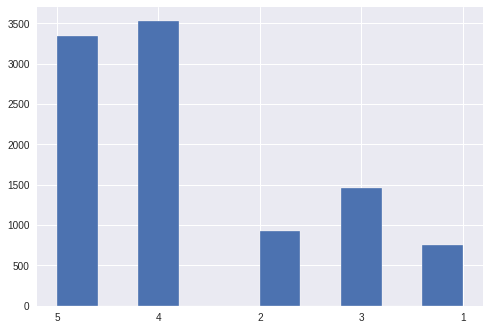

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
plt.hist(raw_json['stars'])

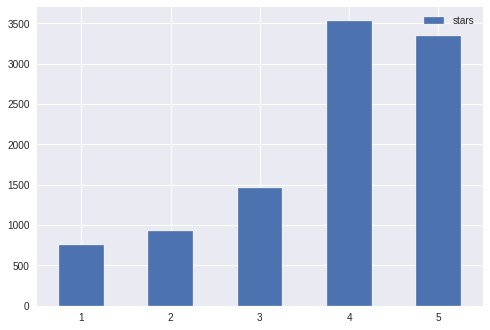

In [53]:
# import hvplot.pandas
df.plot.bar(rot=0)
plt.style.use('seaborn-dark-palette')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


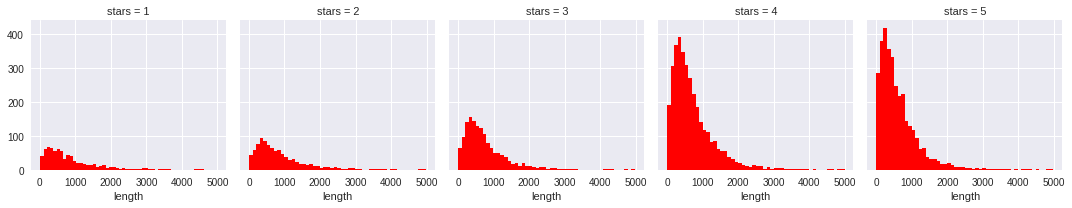

In [15]:
# COMPARING TEXT LENGTH TO STARS
import seaborn as sns
star_length_plot = sns.FacetGrid(data=raw_json,col='stars')
star_length_plot.map(plt.hist,'length',bins=50,color='r')

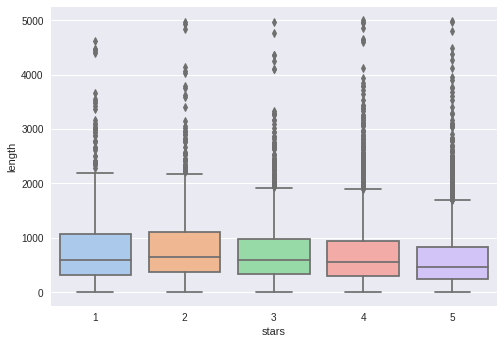

In [16]:
sns.boxplot(x="stars", y="length", data=raw_json, palette="pastel")

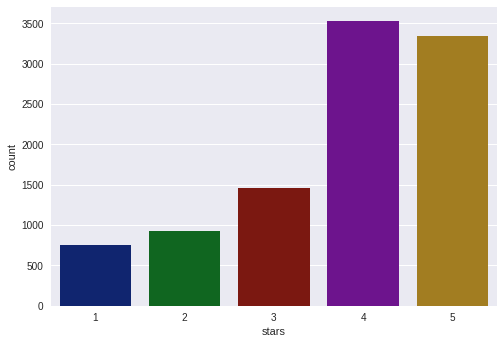

In [17]:
sns.countplot(raw_json["stars"])

In [18]:
review_metrics = raw_json.groupby("stars").mean()
review_metrics

,class,length,cool,useful,funny
stars,,,,,
1,0.0,826.515354,0.576769,1.604806,1.056075
2,0.0,842.256742,0.719525,1.563107,0.875944
3,0.0,758.498289,0.788501,1.306639,0.694730
4,1.0,712.923142,0.954623,1.395916,0.670448
5,1.0,624.999101,0.944261,1.381780,0.608631


In [19]:
review_metrics = review_metrics[['length', 'cool', 'useful', 'funny']]
review_metrics

,length,cool,useful,funny
stars,,,,
1,826.515354,0.576769,1.604806,1.056075
2,842.256742,0.719525,1.563107,0.875944
3,758.498289,0.788501,1.306639,0.694730
4,712.923142,0.954623,1.395916,0.670448
5,624.999101,0.944261,1.381780,0.608631


In [20]:
review_metrics.corr()

,length,cool,useful,funny
length,1.000000,-0.857664,0.699881,0.843461
cool,-0.857664,1.000000,-0.743329,-0.944939
useful,0.699881,-0.743329,1.000000,0.894506
funny,0.843461,-0.944939,0.894506,1.000000


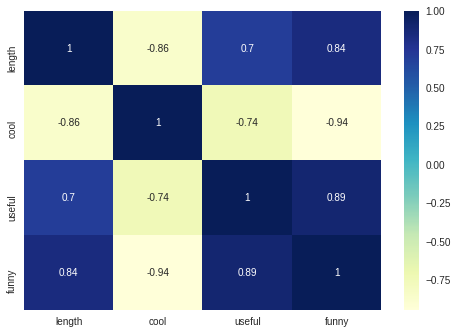

In [21]:
sns.heatmap(review_metrics.corr(), cmap="YlGnBu", annot=True)

In [54]:
df = raw_json.assign(Useful='No')
df.loc[raw_json['useful'] > 0, 'Useful'] = 'Yes'
df

,review_id,stars,class,review_text,length,cool,useful,funny,business_id,user_id,Useful
0,-7yxrdY13ay15rGB7WibMA,5,1,I have been going to Arizona Auto Care since a...,670,0,0,0,Lh9nz0KYyzE-YRbKuCYeUw,ayKW9eWwGFcrtJaHcwZUCw,No
1,-Be0UUGYuiDJVAM_YqeQuA,4,1,"Since Im big into breakfast foods, Im always o...",1348,0,2,2,pa6K7DGByxBXxcVJ59nWMw,_4lqpCYCqOQzbB6xQGGhrQ,Yes
2,-nQHHXi-d_yuW301_Y0EZQ,2,0,"A pleasant place in Kierland Center, but has g...",813,0,0,0,GIGI8bJfN6HyPzmEW-QqjA,4QORbyhfN01oKR_GgBstfQ,No
3,2L30O7G8IQ6HILpR0t5RFA,5,1,"part of a social event, we only had app's here...",415,0,0,0,qiwajZigq_2twTmYofPmDQ,ST8Yzlk2MqKlcaLqL2djBg,No
4,4x5yLG7_yGLuN-w6fV0eBw,4,1,I love every place on South Mountain. I've bee...,302,0,1,0,9yKzy9PApeiPPOUJEtnvkg,Vk-hJ1i5ZagPM87Kv9FOnA,Yes
...,...,...,...,...,...,...,...,...,...,...,...
9995,trszp57AKwKd3LnSidU3aQ,4,1,"Nice people, great food. A really nice white ...",173,0,0,0,49RRQ0nE8XugVuvowiVv2g,1diI7PX0AxbbtiUB7nPbuQ,No
9996,vbUI1pHeVTv0VAK2scZl-w,5,1,Amazing place wish i lived in Phx so i could h...,64,0,0,0,zp713qNhx8d9KCJJnrw1xA,injbO7hPQcusNziz6gyuIg,No
9997,vdxxUwuP9zROlGLQM5kDFw,4,1,*3.5 stars*\n\nIn the interest of supporting l...,2168,0,0,0,5VMajxduxfLPSyQkVFKESg,_qQJEA45k_E6EGE7vuzUDA,No
9998,yeJSQXhPe7OK5JjZ8V_QtQ,3,0,Visited recently for the first time. Enjoyed ...,1161,0,1,0,b5cEoKR8iQliq-yT2_O0LQ,Ud43DdZ6PibSYEtsi18F4A,Yes


In [40]:
# df.groupby('user_id').count()

,review_id,stars,class,review_text,length,cool,useful,funny,business_id,Useful
user_id,,,,,,,,,,
--65q1FpAL_UQtVZ2PTGew,5,5,5,5,5,5,5,5,5,5
--VxRvXk3b8FwsSbC2Zpxw,1,1,1,1,1,1,1,1,1,1
--rlgfAvvi0BtfRDA1p-VQ,1,1,1,1,1,1,1,1,1,1
-2S6keboidRPly-h5lBfkA,1,1,1,1,1,1,1,1,1,1
-2XA34d6OGYEUuzqC7yhBg,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
zwjIdDClpnTqsly-O1Pe7g,1,1,1,1,1,1,1,1,1,1
zxcrlC3cmH5S2TGIxuLwBw,1,1,1,1,1,1,1,1,1,1
zxnoE5IjuWoI9mF1gwyg5w,1,1,1,1,1,1,1,1,1,1


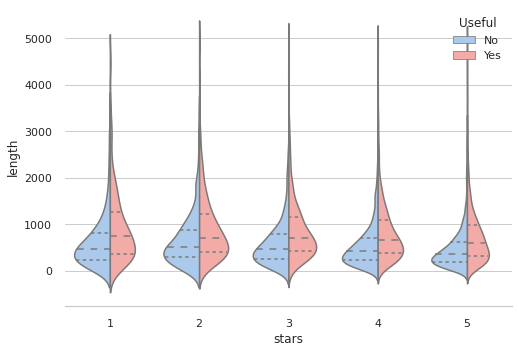

In [56]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="stars", y="length", hue="Useful",
               split=True, inner="quart",
               palette={"Yes": "r", "No": "b"},
               data=df)
sns.despine(left=True)

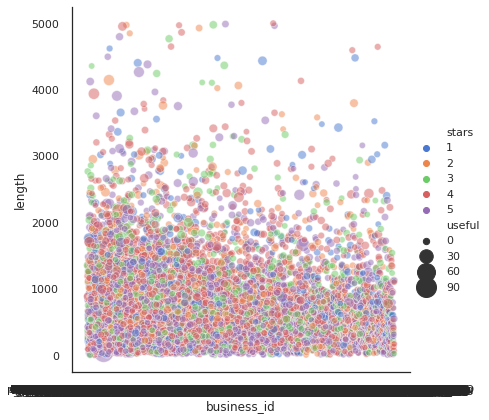

In [55]:
sns.set(style="white")

# Plot business id against length with other semantics
sns.relplot(x="business_id", y="length", hue="stars", size="useful",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

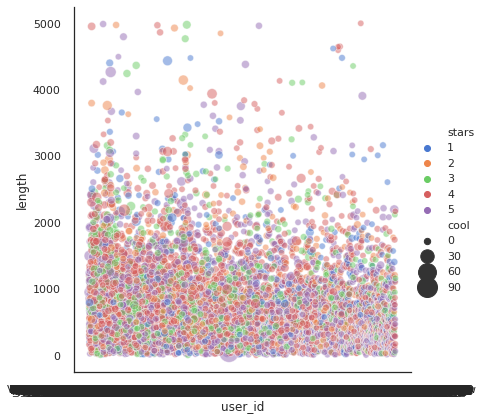

In [57]:
sns.set(style="white")

sns.relplot(x="user_id", y="length", hue="stars", size="cool",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

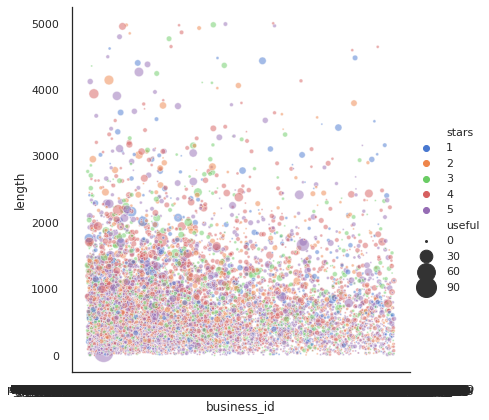

In [58]:
sns.set(style="white")

sns.relplot(x="business_id", y="length", hue="stars", size="useful",
            sizes=(4, 400), alpha=.5, palette="muted",
            height=6, data=df)